## Препроцессинг  & EDA
В рамках данного ноутбука пошагово представлен алгоритм сбора и предобработки данных для датасета вместе с предварительным визуальным анализом текстовых данных.

In [1]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from urllib import parse
import urllib3
from concurrent.futures import ThreadPoolExecutor
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.util import bigrams
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import json
import pandas as pd
import numpy as np
import requests
import time
import random
import re

##### Создание функции для скрейпинга списка вакансий со страницы поиска

In [2]:
def search_data(
  page: int,
  query: str = 'художник',
  excluded: str = '',
  salary: str = '',
  experience: str = 'doesNotMatter',
  order_by: str = 'relevance',
  search_period: int = 0,
  on_page: int = 100
) -> pd.DataFrame:

  """
    This function performs search for vacancies on HH.ru, gets conviniently placed
    JSON formatted data on the page and converts it to dataframe
  """

  time.sleep(random.uniform(0,1))
  http = urllib3.PoolManager()
  urlencoded_query = parse.quote(query, safe='')
  search_url = f'https://hh.ru/search/vacancy?no_magic=true&L_save_area=true&text={urlencoded_query}' \
    f'&excluded_text={excluded}' \
    f'&salary={salary}' \
    f'&currency_code=RUR&experience={experience}' \
    f'&order_by={order_by}' \
    f'&search_period={search_period}' \
    f'&items_on_page={on_page}' \
    f'&page={page}'
  headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    'Accept-Encoding': 'utf-8'
  }
  resp = http.request(
    method='GET',
    url=search_url,
    headers=headers
  )
  soup = BeautifulSoup(resp.data.decode('utf-8', 'ignore'), "html.parser")
  data_templates = soup.find_all('template')
  json_formatted_data = json.loads(data_templates[0].string)
  vacancies_rest = json_formatted_data['vacancySearchResult']['vacancies']
  vacancies_df = pd.DataFrame(
    data=vacancies_rest
  )

  try:
    # dropping snippet which contains of cut description for the vacancy
    vacancies_df = vacancies_df.drop('snippet', axis=1) 
  except:
    pass
    
  return vacancies_df

In [ ]:
urllib3.disable_warnings()

##### Получение списка вакансий постранично

In [ ]:
import dask.dataframe as dd
import multiprocessing as mp

page_noS = [0,1,2,4,5,6,7,8,9,10,11,12,13,14,15]
pool = mp.Pool(processes = mp.cpu_count())
dfs = pool.map(search_data, page_noS)
df = pd.concat(dfs).reset_index()

##### Получение информации по каждой вакансии 
~15мин. через скрейпинг, ~4мин. через API

In [ ]:
import dask
import dask.bag as db

@dask.delayed
def delayed_api_search(id: int) -> dict:

  """
    This function performs simple vacancy's page scrape via API
    with a sole purpose of speeding up asyncio version using dask
  """

  header = {
    'HH-User-Agent': f'Vacancy Scraper/1.0 (yaturkunov@gmail.com)'
  }
  request_url = f'https://api.hh.ru/vacancies/{id}/'
  try:
    response = requests.get(request_url, headers=header).json()
    error_message = response['errors']
    asyncio.sleep(random.uniform(10))
    delayed_api_search(id)
  except:
    return response

@dask.delayed
def delayed_scrape(record: dict) -> dict:

  """
    This function performs simple vacancy's page scrape
  """

  http = urllib3.PoolManager()
  headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36',
    'Accept-Encoding': 'utf-8'
  }
  resp = http.request(
    method='GET',
    url=record['links']['desktop'],
    headers=headers
  )
  output_info = {}
  
  try:
    soup = BeautifulSoup(resp.data.decode('utf-8', 'ignore'), "html.parser")
    json_formatted_data = json.loads(soup.find('script', {'type': 'application/ld+json'}).string)
    patt = re.compile(r'<.*?>')
    output_info['id'] = record['vacancyId']
    output_info['description'] = patt.sub('', json_formatted_data['description'])
    output_info['logo'] = f'https://img.hhcdn.ru{json_formatted_data["hiringOrganization"]["logo"]}'
    output_info['industry'] = json_formatted_data['industry']
  except:
    pass

  return output_info


data_frames = []
records_array = df.to_dict('records')
delayed_objects = [delayed_scrape(rec) for rec in records_array]
descriptions_from_dask = dask.compute(delayed_objects, scheduler="threading")
vacancy_df = pd.DataFrame(descriptions_from_dask[0])
vacancy_df.head()

##### Описание признаков, которые доступны в рамках API, для каждой вакансии:
* `id` (int): идентификатор вакасии
* `premium` (bool): является ли вакансия премиальной. Статус премиальной выбирается работадателем. Премиализация по сути просто помогает поставить вакансию выше других в поиске на 7 дней + еще какие-то привилегии
* `billing_type` (dict: `{id, name}`): тоже тип вакансии по степени ее приоритетности в поиске. Выбирается аналогично работодателем
* `vacancy_relation` (list): отображает список личных откликов на вакансию (например, `вас пригласили`, `добавлено в избраное` и т.д.). Значение всегда пусто без авторизации
* `name` (str): название вакансии
* `insider_interview` (None/dict): наличие ссылки на инсайд-интервью о компании
* `response_letter_required` (bool): необходимость отправлять резюме
* `area` (dict: `{id, name, url}`): область местонахождения вакансии. По ссылке можно получить `parent_id` области
* `salary` (None/dict: {`currency`, `from`, `to`, `gross`}): з/п
* `type` (dict: `{id, name}`): статус вакансии (содержится в `id`). Принимает значение `open` или `closed`
* `adress` (dict: `{city, street, building, lat, lng, description, raw, metro, metro_stations}`): детальная информация о местонахождении HQ
* `allow_messages`: принимают ли рекламодатели письма от искателей
* `experience` (dict: `{id, name}`): информация о необходимости наличия опыта. Нужно смотреть `id`, которое принимает следующие значения:
  * `noExperience` (без опыта)
  * `between1And3` (от 1 и 3 лет)
  * `between3And6` (от 3 до 6 лет)
  * `moreThan6` (более 6 лет)
* `schedule` (dict: `{id, name}`): информация о занятости. Идентификатор `id` занятости принимает следующие значения:
  * `fullDay`: полный день
  * `shift`: сменный график
  * `flexible`: гибкий график
  * `flyInFlyOut`: вахтовый график (когда у работника нет возможности возвращаться домой, поэтому он проводит время отдыха от вахт на рабочем месте. Например экспедиции)
  * `remote`: удаленная работа
* `employment` (dict: `{id, name}`): тип работы. Идентификатор `id` принимает значения:
  * `full`: полная занятость
  * `part`: частичная занятость
  * `project`: проектная работа (работа над конкретным продуктом, не полное трудоустройство)
  * `volunteer`: волонтерство
  * `probation`: стажировка
* `department` (None/dict: {`id`}): в `id` может содержаться идентификатор департамента внутри компании. Узнать название департамента можно фильтром по департаментам компании, которые можно получить по `https://api.hh.ru/employers/{employer_id}/departments`
* `contacts` (None/dict: {`email`, `name`, `phones`}): контакты представителя компании
* `description` (str): описание компании с html-тегами
* `branded_description` (None/str): кастомное описание вакансии с html тегами и собственной стиллизацией, которое добавляется по желанию работодателем
* `vacancy_constructor_template` (None/dict): выбранный работодателем шаблон для описания вакансии
* `key_skills` (None/list): список до 30 словарей формата `{name}` в каждом из `name` которых содержится строка с названием надлежащего скилла
* `accept_handicapped` (bool): указание, что вакансия доступна для соискателей с инвалидностью
* `accept_kids` (bool): указание, что вакансия доступна для соискателей старше 14 лет
* `archived` (bool): находится ли вакансия в архиве, то есть работодатель не оплатил следующий месяц размещения вакансии или вручную отправил ее в архив и она исчезла из поиска
* `response_url` (None/str): внешний URL отклика для прямых вакансий
* `specializations` (list): область(и) специализации в которую(ые) входит вакансия. Возвращает список из словарей формата `{id, name, profarea_id, profarea_name}`. `name` - название более узкой специализации в сфере `profarea_name`
* `professional_roles` (list): список профессиональных ролей состоящий из словарей формата `{id, name}`
* `code` (None/str): внутренний код вакансии в компании
* `hidden` (bool): Скрыта ли вакансия в поиске
* `quick_responses_allowed` (bool): в документации ничего нет, к сожалению
* `driver_license_types` (list): необходимый список категорий водительских прав
* `accept_incomplete_resumes` (bool): разрешен ли отклик на вакансию неполным резюме, то есть без прикрепления полноценного резюме к профилю на hh.ru
* `employer` (dict: {`id`, `name`, `url`, `alternate_url`, `logo_urls`: {`original`, `240`, `90`}, `vacancies_url`, `trusted`}): информация о работодателе. В `vacancies_url` содержится ссылка api-запрос для получения детального описания компании. В `trusted` содержится Boolean флаг, показывающий, прошла ли компания проверку на сайте
* `published_at` (str): дата публикации
* `created_at` (str): дата публикации (как написано в документации)
* `initial_created_at` (str): дата создания вакансии
* `negotiations_url` (None, str): URL, на который нужно сделать GET-запрос, чтобы получить список откликов/приглашений текущего пользователя
* `suitable_resumes_url` (None, str): ссылка на подходящие резюме (в документации нет никаких примеров)
* `apply_alternate_url` (str): ссылка на отклик с формой для заполнения резюме на вакансию
* `has_test` (bool): есть ли тестирование при приеме на вакансию
* `alternate_url` (str): еще какой-то дополнительный URL на вакансию
* `test` (dict: {`id`, `required`}): словарь из тестов необходимых при приеме на вакансию. Названия тестов можно получить по поиску `id` в списке тестирований, которые можно получить по `https://api.hh.ru/employers/{employer_id}/tests`
* `working_days` (None/list): список рабочих дней в виде словарей формата `{id, name}`, в `id` которых могут быть следующие значения:
  * `only_saturday_and_sunday`: работа только по сб и вс
* `working_time_intervals` (None/list): список с временными интервалами работы из словарей формата `{id, name}`, в `id` которых могут быть следующие значения:
  * `from_four_to_six_hours_in_a_day`: можно работать сменами по 4–6 часов в день
* `working_time_modes` (None/list): список режимов времени работы из словарей формата `{id, name}`, в `id` которых могут быть следующие значения:
  * `start_after_sixteen`: можно начинать работать после 16:00
* `accept_temporary` (None/bool): указание, что вакансия доступна с временным трудоустройством. Временное трудоустройство — это оформление на работу по срочному трудовому договору. Срок действия трудового договора определяется потребностью работодателя во временных работниках
* `languages` (list): список из языков требуемых на вакансии, состоящий из словарей формата `{id, level: {id, name}, name}`, где в `id` хранится сокращенное название языка латиницей (например, `eng`), а в `level.id` содержится уровень в международно принятом формате `a1`, `a2` и т.д.

##### Заполнение пустых значений

In [ ]:
for col in df:
  dt = df[col].dtype 
  if dt == int or dt == float:
      df[col].fillna(0)
  elif dt == str:
      df[col].fillna("")
  else:
    df[col].fillna({})

##### Распаковка языков [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING
# extracting languages and creating categorical columns for each row

def extract_languages(record: pd.DataFrame, unique_langs: list):
  if len(record) > 0:
    existing_langs = {lang['name']: lang['level']['id'] for lang in record}
    lang_keys = existing_langs.keys()
    for lang in unique_langs:
      if lang not in lang_keys:
        existing_langs[lang] = '-'
    return existing_langs
  else:
    return record

def populate_languages():

  """
    This function creates columns in existing dataframe for each language
    and fills them with either '-' or language level ranging from lowest 'a1' to
    the highest (native speaker) 'l1'
  """

  mask = vacancy_df['languages'].str.len() > 0
  masked_index = vacancy_df[mask].index
  unique_languages = vacancy_df['languages'][mask].explode().apply(lambda x: x['name']).unique().tolist()

  langs = vacancy_df['languages'][mask].apply(lambda x: extract_languages(x, unique_languages))
  langs_df = pd.DataFrame(langs[mask].values.tolist())
  langs_df.index = masked_index

  return langs_df

# populating columns for each unique language
languages_df = populate_languages()
vacancy_df[languages_df.columns] = '-'
vacancy_df.loc[languages_df.index, languages_df.columns] = languages_df
vacancy_df.head(1)

##### Получение географии (город и регион) [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING
# extracting geographical data about vacancies

import asyncio
from aiohttp import ClientSession

async def get_parent_area(session: ClientSession, area_id: str):

  """
    This function extracts names of parent areas that the initial 
    area belongs to
  """

  response = await session.get(
    url=f'https://api.hh.ru/areas/{area_id}', 
    headers={'HH-User-Agent': 'Vacancy Researcher/1.0 (joshjson@gmail.com)'},
  )
  json_data = {}
  try:
    json_data = await response.json(content_type=None)
    try: # check if there are any errors present
      errors = json_data['errors']
      if len(errors) > 0: # sleep 10s if too many requests
        await asyncio.sleep(10)
        await get_parent_area(session, area_id)
      else: # return empty object if area id is not found
        return json_data 
    except: # move here if no errors have been found
      parent_id = json_data["parent_id"]
      if parent_id is not None:
        parent_response = await session.get(
          url=f'https://api.hh.ru/areas/{parent_id}', 
          headers={'HH-User-Agent': 'Vacancy Researcher/1.0 (joshjson@gmail.com)'},
        )
        json_data = await parent_response.json(content_type=None)
        return json_data # return parent id
      else:
        return json_data # return current id
  except json.decoder.JSONDecodeError as e:
    pass
  return json_data # return empty if json decoder has run into an error

async def extract_parent_geodata(df: pd.DataFrame):

  """
    This function extracts names of areas where vacancies are located
  """

  # extracting locations from dictionary
  areas_df = pd.DataFrame(df['area'].values.tolist())
  areas_df = areas_df[['name', 'id']].astype({'id': 'int64'})
  unique_areas = areas_df[areas_df['name'].notnull()]['id'].unique().tolist()
  detailed_parent_areas = []

  # extracting information about parent areas via async requests to API
  cs = ClientSession()
  detailed_parent_areas = await asyncio.gather(*[get_parent_area(cs, child_area) for child_area in unique_areas])
  await cs.close()

  # creating dataframe of child location IDs and their parent location names
  areas_df_ = pd.DataFrame(detailed_parent_areas)

  # joing original table of locations with previously generated dataframe
  # of parent location names by "id" column
  merged_columns = areas_df.merge(pd.DataFrame(zip(unique_areas, areas_df_['name']), columns=['id', 'parent_name']).astype({'id': 'int64'}), on='id')
  merged_columns.columns = ['child_loc_name', 'child_loc_id', 'parent_loc_name']
  return pd.concat([df, merged_columns], axis=1)

vacancy_df = await extract_parent_geodata(vacancy_df)
vacancy_df.head(1)

##### Распаковка атрибутов, которые получаются в виде словарей [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING
# extracting categorical values from dict-only columns

def extract_dict_values(record):
  try:
    return pd.DataFrame(record.values.tolist())['id']
  except:
    pass

dict_cols = ['experience', 'schedule', 'employment', 'type', 'department']
vacancy_df.loc[:, dict_cols] = vacancy_df[dict_cols].apply(extract_dict_values, axis=0)
vacancy_df[dict_cols]

##### Очистка описаний от HTML тэгов

In [ ]:
# PREPROCESSING
# clearing descriptions (getting rid of tags)

import re

previous_shape = vacancy_df.shape[0]
vacancy_df['description'] = vacancy_df['description'].str.replace(re.compile(r'<.*?>'), '')
vacancy_df = vacancy_df[~vacancy_df['description'].duplicated()]
vacancy_df.shape[0], previous_shape

##### Очистка столбца с тестовыми заданиями [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING
# fixing up the column with tests

vacancy_df['test'][~vacancy_df['test'].notnull()] = False
vacancy_df.loc[:, 'test'][vacancy_df['test'] != False] = pd.DataFrame.from_records(vacancy_df['test'][vacancy_df['test'] != False].tolist())['required']
vacancy_df.head(1)

##### Распаковка атрибутов, которые получаются в виде списков [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING 
# analysing and unpacking columns that contain lists of dictionaries

def unpack_list_to_cols(df: pd.DataFrame, cols: list):

  """
    Unpacks lists of dictionary and creates columns based on unique keys
    in these dictionaries and creates one-hot encoded columns
  """

  cols_unpacked = []

  for col in cols:
    nonempty = df[col].str.len() > 0

    # unpacking dictionaries and making a dataframe out of them
    unique_keys = pd.DataFrame(df[col][nonempty].explode().values.tolist())['id'].unique()
    unpacked = pd.DataFrame(df[col][nonempty].values.tolist())
    unpacked.columns = unique_keys

    # one-hot encoding unique key-related columns
    unpacked[unpacked.notnull()] = 1
    unpacked[~unpacked.notnull()] = np.nan
    unpacked.index = df[nonempty].index

    # creating new cols in existing dataframe
    df.loc[df[nonempty].index, unique_keys] = unpacked

    cols_unpacked += unique_keys.tolist()

  return cols_unpacked

list_cols = ['working_time_modes', 'working_time_intervals', 'working_days']
unpacked_columns = unpack_list_to_cols(vacancy_df, list_cols)
vacancy_df[vacancy_df[unpacked_columns[0]].isna()].head(1) # checking where start_after_sixteen is False

##### Препроцессинг столбца с з/п
* 0, если она отсутствует
* конверсия в рубли
* вычет НДФЛ если отсутствует флаг "net"

In [ ]:
# PREPROCESSING
# adjusting the salary rate

def fix_compensation(record: pd.DataFrame):

  """
    This function fixes compensation column by subtracting taxes that may not
    be included in the salary. It also checks for salary range and 
    subtracts 15% from compensations without determined price range.
  """


  if isinstance(record, float):
    return 0.

  try:
    _ = record['noCompensation']
    return 0.
  except:
    pass

  minimum_wage_ru = 16242

  try:
    record['to'] = record['to']
  except:
    record['to'] = None

  try:
    record['from'] = record['from']
  except:
    record['from'] = None

  compensation = record['to'] if record['to'] is not None else record['from']

  if None not in [record['to'], record['from']]:
    compensation = (record['to'] + record['from']) / 2

  # converting to RUB
  try:
    cur = record['currencyCode']
    if cur != 'RUR':
      url = f'https://api.exchangerate.host/convert?from={cur}&to=RUB'
      convertion_rate = requests.get(url).json()['result']
      if convertion_rate is not None:
        compensation *= convertion_rate
  except:
    pass

  # calculating net
  try:
    _ = record['gross']
    if record['gross']:
      compensation = compensation * .87 if compensation < 5_000_000 else compensation * .85
  except:
    pass

  compensation = compensation if compensation >= minimum_wage_ru else minimum_wage_ru
  
  return compensation

vacancy_df['compensation'] = vacancy_df['compensation'].apply(fix_compensation)

##### Распаковка ролей [работает только при получении вакансий через API]

In [ ]:
# PREPROCESSING
# extracting professional_roles

def extract_professional_roles(roles_column: pd.Series):

  """
    Effieicently extracting role names from "professional_roles"
  """

  updated_roles_column = pd.DataFrame(roles_column.explode().values.tolist())['name']
  updated_roles_column.index = roles_column.index
  return updated_roles_column

non_empty = vacancy_df['professional_roles'].str.len() > 0
vacancy_df['professional_roles'][non_empty] = extract_professional_roles(vacancy_df['professional_roles'][non_empty])
vacancy_df['professional_roles']

##### Избавление от бесполезных признаков [работает только при получении вакансий через API]

In [ ]:
useful_columns = [
	'response_letter_required', 
	'child_loc_name',
	'parent_loc_name',
	'experience',
	'schedule',
	'employment',
	'accept_handicapped',
	'accept_kids',
	'archived',
	'professional_roles',
	'accept_incomplete_resumes',
	'has_test',
	'accept_temporary'
] + languages_df.columns.tolist() + unpacked_columns
learning_df = vacancy_df.copy()
learning_df = learning_df[learning_df['salary'] > 0]
y = learning_df['salary']
x = learning_df[useful_columns]

##### Корректировка типов данных столбцов + заполнение пустых значений, образовавшихся в результате распаковки признаков [работает только при получении вакансий через API]

In [ ]:
learning_df = pd.concat([x, y], axis=1)
learning_df.dropna(subset=['parent_loc_name'], inplace=True) # we can do this, because we'll be getting rid of only 11 columns
learning_df.fillna(
  {
   'start_after_sixteen': '-', 
   'from_four_to_six_hours_in_a_day': '-',
   'only_saturday_and_sunday': '-'
  }, 
  inplace=True
)
str_cols = [dfcol for dfcol in x.columns if learning_df[dfcol].dtype == 'object' and dfcol != 'salary']
learning_df[str_cols] = learning_df[str_cols].astype(str)
learning_df['salary'] = learning_df['salary'].astype(float)

##### Энкодинг категориальных столбцов 
Нужно менять "salary" на "compensation" при получении данных о вакансиях не через API, а через веб-скрейпинг

In [ ]:
class OrdinalEncoderLabeled(OrdinalEncoder):

  def __init__(self, df: pd.DataFrame):
    self.df = df
    super().__init__()

  def get_labels(self):
    label_dict = {}
    for col in self.df.columns:
      sorted_uniques = self.df[col].sort_values().unique()
      label_dict[col] = list(zip(
        list(range(len(sorted_uniques))), sorted_uniques
      ))
    return label_dict

enc = OrdinalEncoderLabeled(learning_df.loc[:, ~learning_df.columns.isin(['salary'])])
encoded_array = enc.fit_transform(learning_df.loc[:, ~learning_df.columns.isin(['salary'])].to_numpy())
learning_df.loc[:, ~learning_df.columns.isin(['salary'])] = encoded_array
learning_df.head(2)

##### Загрузка получившегося датасета с препроцессингом
Производим анализ текстовых данных (потому что влияние других факторов не было доказано)

In [2]:
from textprocessing import preprocessingWrapper

text_df = pd.read_excel('vacancies_df.xlsx', index_col=0)
text_df = text_df[~text_df['description'].duplicated()]
wrapper = preprocessingWrapper()
text_df['preprocessed_desc'] = wrapper(text_df, 'description')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Кластеризация вакансий
Попытки выделения кластеров вакансий на основе нескольких признаков, чтобы затем можно было на их основе сформировать логику DQN модели. Хотя у нас уже есть разделение по сферам (`industry`), была выдвинута теория о том, что можно будет найти более узкие сообщества вакансий. 


In [5]:
from sklearn.cluster import Birch, MiniBatchKMeans
# one-hot encoding уникальных названий вакансий
import numpy as np

def words2idxmapping(words_array, word2idx_dict):
  return [word2idx_dict[word] for word in words_array]

def create_onehot_masked_df(column_of_seqs, list_is_string=False):
    """
    Функция, получающая на вход столбец из списков column_of_seqs и
    флаг, отмечающий являются ли записи списками или это строка со списком
    """
    column_of_seqs.fillna("", inplace=True)
    if list_is_string:
        column_of_seqs = column_of_seqs.str.replace("'",'').str.replace('[','') \
        .str.replace(']','').str.replace('\s*','',regex=True).str.split(',')
    unique_names = column_of_seqs.explode().unique()
    idx2word = {idx: name for idx, name in enumerate(unique_names)}
    word2idx = {name: idx for idx, name in idx2word.items()}
    seqs2idx = column_of_seqs.apply(
        lambda words: words2idxmapping(words, word2idx)
    )
    onehot_mask = np.zeros((column_of_seqs.shape[0],len(unique_names)))
    for indx, namesmapping in enumerate(seqs2idx.values):
        onehot_mask[indx, namesmapping] = 1
    
    return pd.DataFrame(onehot_mask,columns=unique_names)

onehot_names = create_onehot_masked_df(wrapper(text_df, 'name')) # onehot encoded названия вакансии
onehot_industries = create_onehot_masked_df(text_df['industry'], list_is_string=True) # onehot encoded сферы

In [6]:
from sklearn.preprocessing import OrdinalEncoder

class OrdinalEncoderLabeled(OrdinalEncoder):
  def __init__(self, df: pd.DataFrame):
    self.df = df
    super().__init__()

  def get_labels(self):
    label_dict = {}
    for col in self.df.columns:
      sorted_uniques = self.df[col].sort_values().unique()
      label_dict[col] = list(zip(
        list(range(len(sorted_uniques))), sorted_uniques
      ))
    return label_dict

categorical_columns = ['@workSchedule', 'workExperience']
enc = OrdinalEncoderLabeled(text_df.loc[:, categorical_columns])
encoded_array = enc.fit_transform(text_df.loc[:, categorical_columns].to_numpy())
categorical_df = pd.DataFrame(encoded_array, columns=categorical_columns)

# объединение датафрейма с категориальными столбцами вместе с onehot encoded
df_for_clustering = pd.concat([categorical_df, onehot_names, onehot_industries],axis=1)
df_for_clustering.head(1)

,@workSchedule,workExperience,художник,окружен,колорист,графическ,дизайнер,на,ювелирн,производств,...,Консультирование,Управлениеперсоналом,тренинги,Бухгалтерия,управленческийучет,финансыпредприятия,Юристы,Медицина,фармацевтика,Инсталляцияисервис
0,1.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


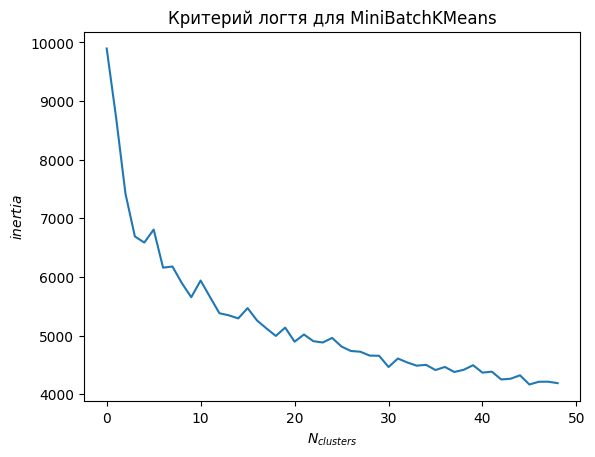

In [9]:
import matplotlib.pyplot as plt

inertias = []
for cluster_count in range(1,50):
    model = MiniBatchKMeans(n_clusters=cluster_count,n_init='auto')
    model.fit(df_for_clustering)
    inertias.append(model.inertia_)
plt.plot(inertias)
plt.title('Критерий логтя для MiniBatchKMeans')
plt.xlabel('$N_{clusters}$')
plt.ylabel('$inertia$')
None

**Вывод:** Кластеризовать по нескольким признакам нельзя, так как интенсивность уменьшения `inertia_` снижается с более большим количеством кластеров и в то же время само значение `inertia_` сильно высоко

#### Статистический анализ распределения з/п

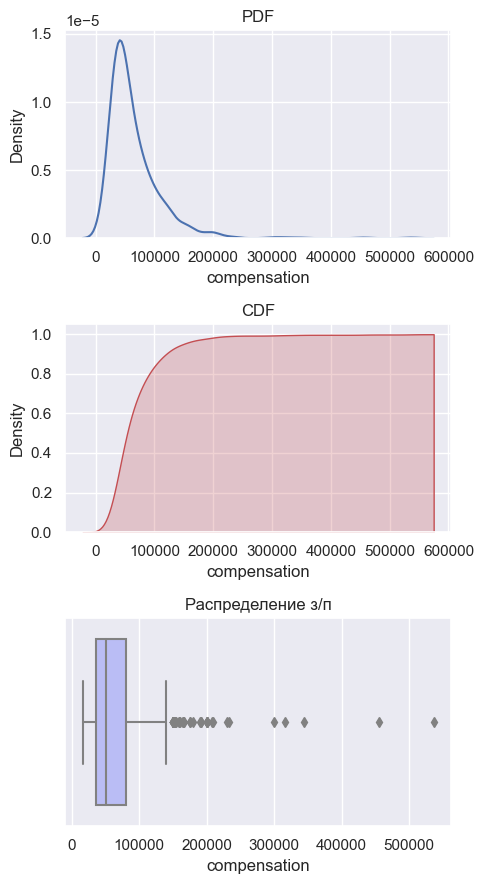

In [5]:
sns.set(style='darkgrid')
fig, axs = plt.subplots(3, 1, figsize=(5,9))
with_comp = text_df[text_df['compensation'] > 0]
sns.kdeplot(data=with_comp, x='compensation', ax=axs[0])
sns.kdeplot(data=with_comp, x='compensation', cumulative=True, ax=axs[1], color='r', fill=True)
sns.boxplot(data=with_comp, x='compensation', ax=axs[2], color=(176/255, 180/255, 255/255))
axs[0].set(title='PDF')
axs[1].set(title='CDF')
axs[2].set(title='Распределение з/п')
fig.tight_layout()

#### Исследование зависимости между словами и з/п

In [7]:
from nltk import FreqDist

stemmed_words = text_df['preprocessed_desc'].str.join(' ')
sorted_frequencies = sorted(dict(FreqDist(
  text_df['preprocessed_desc'].explode()
)).items(), key=lambda kv: kv[1], reverse=True)
top_words = pd.DataFrame(sorted_frequencies, columns=['word', 'occurencies'])
top_words['av_compensation'] = top_words.word.apply(
  lambda word: 
    text_df['compensation'][stemmed_words.str.contains(word)].mean()
)
top_words.iloc[:10,:]

,word,occurencies,av_compensation
0,и,12550,38574.768272
1,.,11391,37237.094856
2,в,9051,38607.021423
3,с,4935,38574.768272
4,работ,4779,38682.229370
5,на,3498,38456.991378
6,для,2476,39233.314537
7,по,2421,38706.047407
8,мы,2313,39641.710618
9,оп,1859,38609.195186


C:\Users\user\AppData\Local\Temp\ipykernel_6312\4244636470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words['compensation_class'][
C:\Users\user\AppData\Local\Temp\ipykernel_6312\4244636470.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words['compensation_class'][
C:\Users\user\AppData\Local\Temp\ipykernel_6312\4244636470.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_words['compensation_class'][
C:\Use

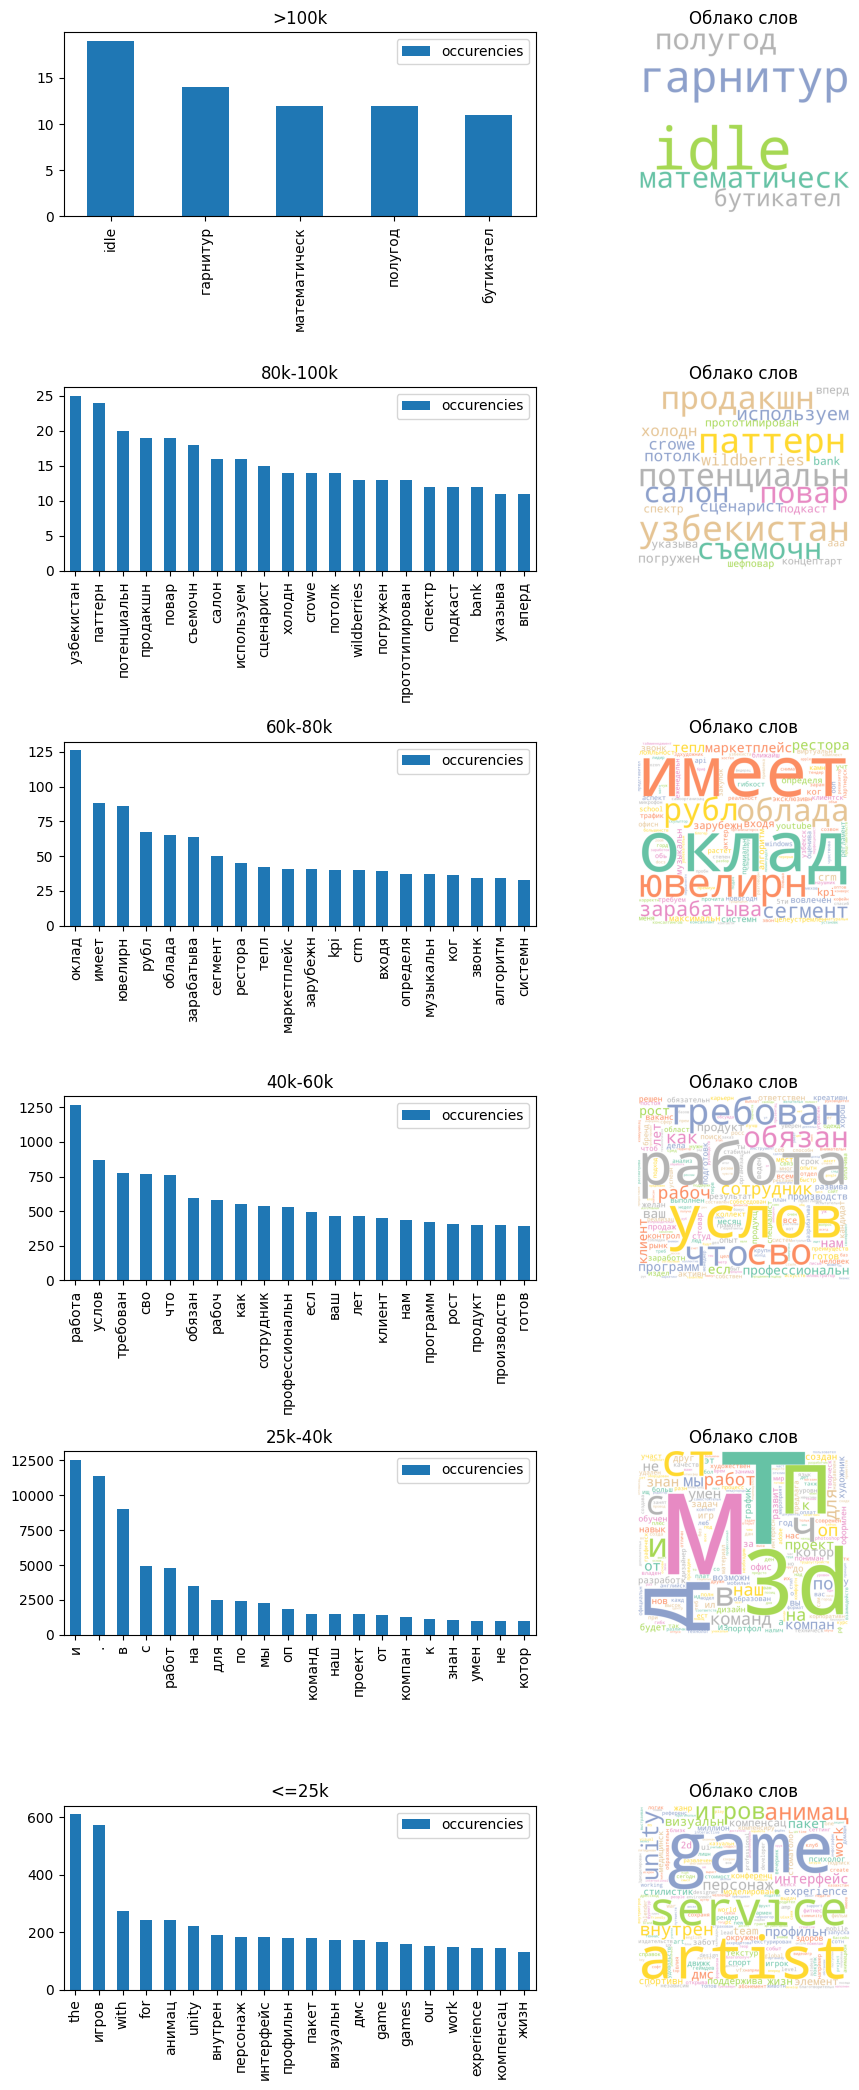

In [8]:
from wordcloud import WordCloud

top_words['compensation_class'] = '>100k'
top_words['compensation_class'][
  (top_words['av_compensation'] > 80000) & (top_words['av_compensation'] <= 100000)
] = '80k-100k'

top_words['compensation_class'][
  (top_words['av_compensation'] > 60000) & (top_words['av_compensation'] <= 80000)
] = '60k-80k'

top_words['compensation_class'][
  (top_words['av_compensation'] > 40000) & (top_words['av_compensation'] <= 60000)
] = '40k-60k'

top_words['compensation_class'][
  (top_words['av_compensation'] > 25000) & (top_words['av_compensation'] <= 40000)
] = '25k-40k'

top_words['compensation_class'][
  (top_words['av_compensation'] <= 25000)
] = '<=25k'

interesting_words = top_words.sort_values(by='av_compensation', ascending=False)[
  (top_words['occurencies'] > 10) &
  (top_words['av_compensation'] > 0)  
]

fig, axs = plt.subplots(6, 2, figsize=(10, 21))
for index, compType in enumerate(interesting_words['compensation_class'].unique().tolist()):
  words = interesting_words[
    interesting_words['compensation_class'] == compType
  ].sort_values(by='occurencies', ascending=False)
  max_word_count = 20 if words.shape[0] > 20 else words.shape[0]
  words.iloc[:max_word_count, :].plot.bar(x='word',y='occurencies',ax=axs[index, 0],)
  wordcloud = WordCloud(
    width=2028,height=1760,
    background_color='white',colormap='Set2'
  ).generate(' '.join(words['word'].values.tolist()))
  axs[index, 1].imshow(wordcloud)
  axs[index, 1].axis('off')
  axs[index, 0].set(title=compType, xlabel='')
  axs[index, 1].set(title='Облако слов')
fig.tight_layout()